In [416]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression
import tsfel
from itertools import product
from sklearn.ensemble import RandomForestClassifier
plt.style.use('ggplot')

In [417]:
from MakeDataset import *

In [418]:
# Dataset Given
# X_train , y_train
# X_test  , y_test
# X_val   , y_val 
# X_merged, y_merged --> train + validation.

#Merging X_train and X_val dataset
X_merged = np.concatenate((X_train, X_val), axis=0)
Y_merged = np.concatenate((y_train, y_val), axis=0)
activity_classes = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']


In [419]:
# Reshaping the matrix from (_,500,3) --> (_,1500) to matrix to generate 1500 features
X_train_flat = X_train.reshape((-1,1500))
X_test_flat  = X_test.reshape((-1,1500))
X_val_flat   = X_val.reshape((-1,1500))
X_merged_flat   = X_merged.reshape((-1,1500))
X_total_flat = np.concatenate((X_train_flat, X_test_flat), axis=0)
y_total = np.concatenate((y_train, y_test), axis=0)

In [420]:
accx = X_merged[:, :, 0]
accy = X_merged[:, :, 1]
accz = X_merged[:, :, 2]

# Evaluting total/linear acceleration
total_acceleration_2d = accx**2 + accy**2 + accz**2
print(f"Shape of total_acceleration_2d: {total_acceleration_2d.shape}")

#Reshaping/Flatening the total_acceleration matrix to (114,500) 
total_acceleration_2d_ = total_acceleration_2d.reshape((144, 500))

Shape of total_acceleration_2d: (144, 500)


In [421]:
# Retrieves a pre-defined feature configuration file to extract all available features
cfg = tsfel.get_features_by_domain()
print(total_acceleration_2d.shape)

# Extract features
X_train_extracted = tsfel.time_series_features_extractor(cfg, X_merged.reshape((-1,3)),fs=5,window_size=500)
X_test_extracted = tsfel.time_series_features_extractor(cfg, X_test.reshape((-1,3)),fs=5,window_size=500)
print("Shape of extracted matrix ",X_train_extracted.shape)


(144, 500)
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
Shape of extracted matrix  (144, 1152)


In [422]:
X = pd.concat([X_train_extracted, X_test_extracted])
y = np.concatenate((Y_merged, y_test), axis=0)
y = pd.DataFrame(y, columns=['Activity'])

In [423]:
decision_tree = DecisionTreeClassifier(criterion='entropy',max_depth=10,random_state=0)

# Define hyperparameters for decision tree
hyperparameters = {
    'max_depth': [4, 5, 6, 7, 8],
    'min_samples_split': [2, 3, 4, ],
    'criterion': ['gini', 'entropy']
}

# Initialize lists to store results
outer_fold_accuracies = []
outer_fold_opt_depth = []
outer_fold_opt_minsamples = []
outer_fold_opt_criterion = []
# Perform outer k-fold cross-validation
k = 5
outer_fold_size = len(X) // k

for outer_fold in range(k):
    # Split data into outer training and test sets
    test_start = outer_fold * outer_fold_size
    test_end = (outer_fold + 1) * outer_fold_size
    test_set = X[test_start:test_end]
    test_labels = y[test_start:test_end]

    train_set = pd.concat((X[:test_start], X[test_end:]), axis=0)
    train_labels = pd.concat((y[:test_start], y[test_end:]), axis=0)

    # Initialize variables for optimal hyperparameters and accuracy
    best_max_depth = None
    best_min_samples_split = None
    best_criterion = None
    best_accuracy = 0.0

    # Perform inner k-fold cross-validation to find optimal hyperparameters
    inner_fold_size = len(train_set) // k

    for inner_fold in range(k):
        val_start = inner_fold * inner_fold_size
        val_end = (inner_fold + 1) * inner_fold_size
        val_set = train_set[val_start:val_end]
        val_labels = train_labels[val_start:val_end]
        training_set = pd.concat((train_set[:val_start], train_set[val_end:]), axis=0)
        training_labels = pd.concat((train_labels[:val_start], train_labels[val_end:]), axis=0)
        # Grid search over hyperparameters
        for max_depth, min_samples_split,criterion in product(hyperparameters['max_depth'], 
                                                              hyperparameters['min_samples_split'],
                                                              hyperparameters['criterion']):
            decision_tree = DecisionTreeClassifier(criterion=criterion,
                                                   max_depth=max_depth,
                                                   random_state=0,
                                                   min_samples_split=min_samples_split)
            decision_tree.fit(training_set, training_labels)
            val_pred = decision_tree.predict(val_set)
            val_accuracy = accuracy_score(val_labels, val_pred)

            # Update optimal hyperparameters if better accuracy is found
            if val_accuracy > best_accuracy:
                best_max_depth = max_depth
                best_min_samples_split = min_samples_split
                best_criterion = criterion
                best_accuracy = val_accuracy
        outer_fold_opt_depth.append(best_max_depth)       
        outer_fold_opt_minsamples.append(best_min_samples_split)
        outer_fold_opt_criterion.append(best_criterion)
        
    # Train decision tree on combined train + validation data with optimal hyperparameters
    decision_tree = DecisionTreeClassifier(criterion=best_criterion,
                                           max_depth=best_max_depth,
                                           random_state=0,
                                           min_samples_split=best_min_samples_split)
    decision_tree.fit(train_set, train_labels)
    
    # Evaluate accuracy on test data
    test_pred = decision_tree.predict(test_set)
    test_accuracy = accuracy_score(test_labels, test_pred)
    outer_fold_accuracies.append(test_accuracy)

print("Optimal Depth Decision Tree Accuracies, Optimal Depth and Minimum sample split for Each Outer Fold:")
for outer_fold, accuracy_value in enumerate(outer_fold_accuracies, 1):
    print(f"Outer Fold {outer_fold}: Accuracy = {accuracy_value:.4f}, optimal depth = {outer_fold_opt_depth[outer_fold]}, criterion = {outer_fold_opt_criterion[outer_fold]},min sample split = {outer_fold_opt_minsamples[outer_fold]}")

Optimal Depth Decision Tree Accuracies, Optimal Depth and Minimum sample split for Each Outer Fold:
Outer Fold 1: Accuracy = 0.7778, optimal depth = 4, criterion = gini,min sample split = 2
Outer Fold 2: Accuracy = 0.8333, optimal depth = 5, criterion = entropy,min sample split = 2
Outer Fold 3: Accuracy = 0.7500, optimal depth = 5, criterion = entropy,min sample split = 2
Outer Fold 4: Accuracy = 0.8889, optimal depth = 5, criterion = entropy,min sample split = 2
Outer Fold 5: Accuracy = 0.9167, optimal depth = 4, criterion = gini,min sample split = 2


In [424]:
best_min_samples_split = 2
best_max_depth = 5
best_criterion = 'entropy'

# Train decision tree on combined train + validation data with optimal hyperparameters
decision_tree = DecisionTreeClassifier(criterion=best_criterion,
                                       max_depth=best_max_depth,
                                       random_state=0,
                                       min_samples_split=best_min_samples_split)
decision_tree.fit(X_train_extracted, Y_merged)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)

In [425]:
y_pred = decision_tree.predict(X_test_extracted)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy",accuracy)

Accuracy 0.8888888888888888


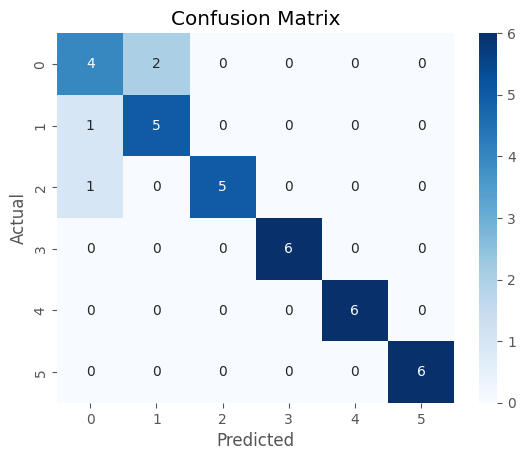

In [426]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [427]:
# Instantiate the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=30, random_state=42,bootstrap=True,max_features='sqrt',max_depth=10)

# Fit the model to the training data
rf_classifier.fit(X_train_extracted, Y_merged)

# Predict on the testing data
y_pred = rf_classifier.predict(X_test_extracted)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9722222222222222


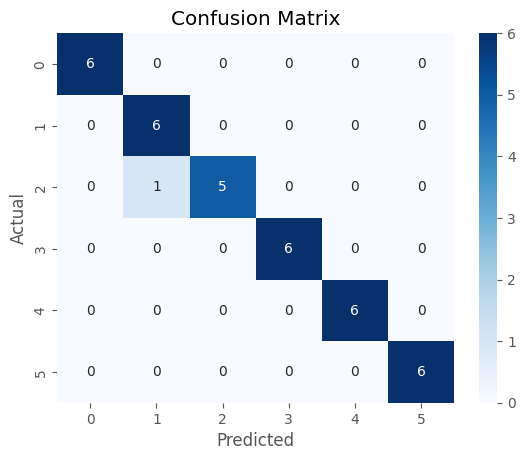

In [428]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [429]:
# Instantiate the Linear Regression model
linear_reg = LinearRegression()

# Fit the model to the training data
linear_reg.fit(X_train_extracted, Y_merged)

# Predict on the testing data
y_pred = linear_reg.predict(X_test_extracted)

print(y_pred)
print(X_train_extracted.shape)
print(y_test.shape)


[1.99852444 3.34749712 6.18723892 0.76548703 6.15676661 5.3133829
 6.20463128 1.42312521 0.13597511 3.83327442 4.0650259  6.0341479
 1.37317596 3.69589201 2.61354331 3.73662359 5.57027486 4.62787214
 0.33918579 5.0293928  5.7639411  0.21437967 1.63363162 4.42424115
 3.97331558 0.68954998 3.66572921 6.07965142 1.59161915 3.99936289
 3.92008197 4.35020578 4.40138698 2.12503974 3.13252417 0.77682493]
(144, 1152)
(36,)


In [430]:
y_pred = np.floor(y_pred)
y_pred

array([1., 3., 6., 0., 6., 5., 6., 1., 0., 3., 4., 6., 1., 3., 2., 3., 5.,
       4., 0., 5., 5., 0., 1., 4., 3., 0., 3., 6., 1., 3., 3., 4., 4., 2.,
       3., 0.])

In [431]:
y_pred[y_pred == 0] = 1
y_pred

array([1., 3., 6., 1., 6., 5., 6., 1., 1., 3., 4., 6., 1., 3., 2., 3., 5.,
       4., 1., 5., 5., 1., 1., 4., 3., 1., 3., 6., 1., 3., 3., 4., 4., 2.,
       3., 1.])

In [432]:
y_test

array([3, 3, 6, 2, 6, 5, 6, 1, 1, 3, 5, 6, 1, 5, 3, 4, 5, 5, 1, 6, 4, 1,
       2, 5, 2, 1, 3, 6, 3, 4, 4, 4, 4, 2, 2, 2])

In [433]:
acc = accuracy_score(y_test, y_pred)
acc

0.5277777777777778

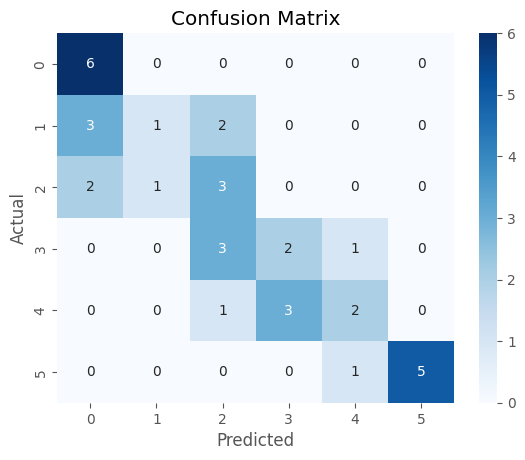

In [434]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [435]:
coef_lr = linear_reg.coef_
coef_lr = np.abs(coef_lr)

coef_lr = coef_lr / np.sum(coef_lr)
coef_lr

array([1.13168734e-04, 1.19833474e-03, 1.13168734e-04, ...,
       1.39219881e-03, 2.11533254e-03, 8.94687982e-05])

In [436]:
linear_reg.intercept_

-238.13017161538377

In [437]:
rf_feature_importeaces = rf_classifier.feature_importances_

In [464]:
weights_lr_normalized = coef_lr
len(weights_lr_normalized[weights_lr_normalized  0])

23

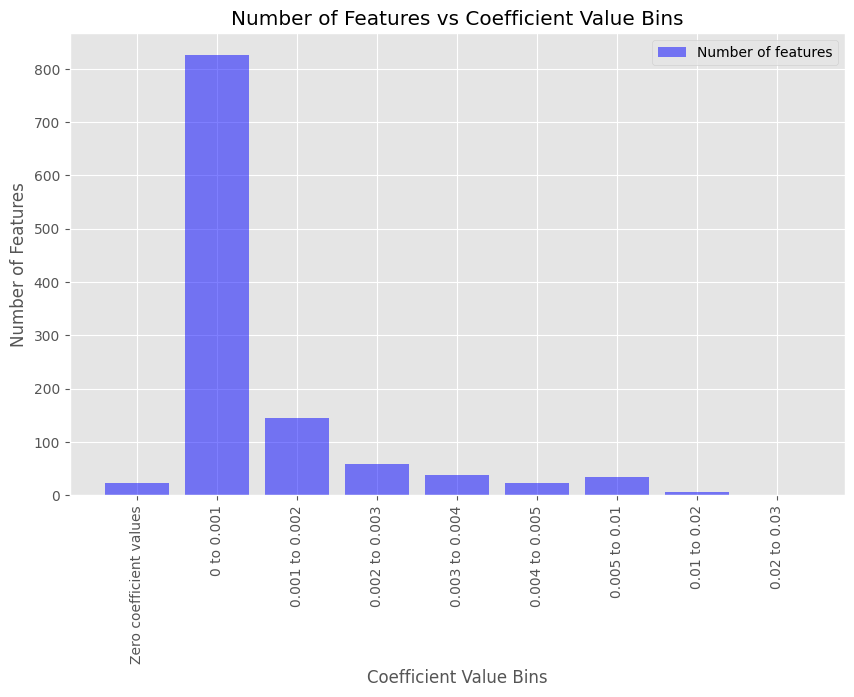

[23, 826, 144, 58, 38, 23, 34, 6, 0]


In [475]:


# Calculate the number of features having mean weights within each bin range
bins = [0,0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.02, 0.03]

grouped_weights_lr_x = []
grouped_weights_lr = []

for i in range(0, len(bins) - 1):
    weights_in_bin = weights_lr_normalized[(weights_lr_normalized > bins[i]) & (weights_lr_normalized <= bins[i+1])]
    if len(weights_in_bin) > 0:
        grouped_weights_lr_x.append(len(weights_in_bin))
        grouped_weights_lr.append(weights_in_bin.mean())
    else:
        grouped_weights_lr_x.append(0)
        grouped_weights_lr.append(0)

grouped_weights_lr_x.insert(0, len(weights_lr_normalized[weights_lr_normalized == bins[0]]))
grouped_weights_lr.insert(0, weights_lr_normalized[weights_lr_normalized == bins[0]].mean())

# Plotting grouped Linear Regression weights
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(grouped_weights_lr)), grouped_weights_lr_x, color='blue', alpha=0.5, label='Number of features')
ax.set_xticks(range(len(grouped_weights_lr)))
ax.set_xticklabels(['Zero coefficient values'] + [f'{bins[i]} to {bins[i+1]}' for i in range(0,len(bins)-1)], rotation=90)
ax.set_xlabel('Coefficient Value Bins')
ax.set_ylabel('Number of Features')
ax.set_title('Number of Features vs Coefficient Value Bins')
ax.legend()
plt.show()

print(grouped_weights_lr_x)


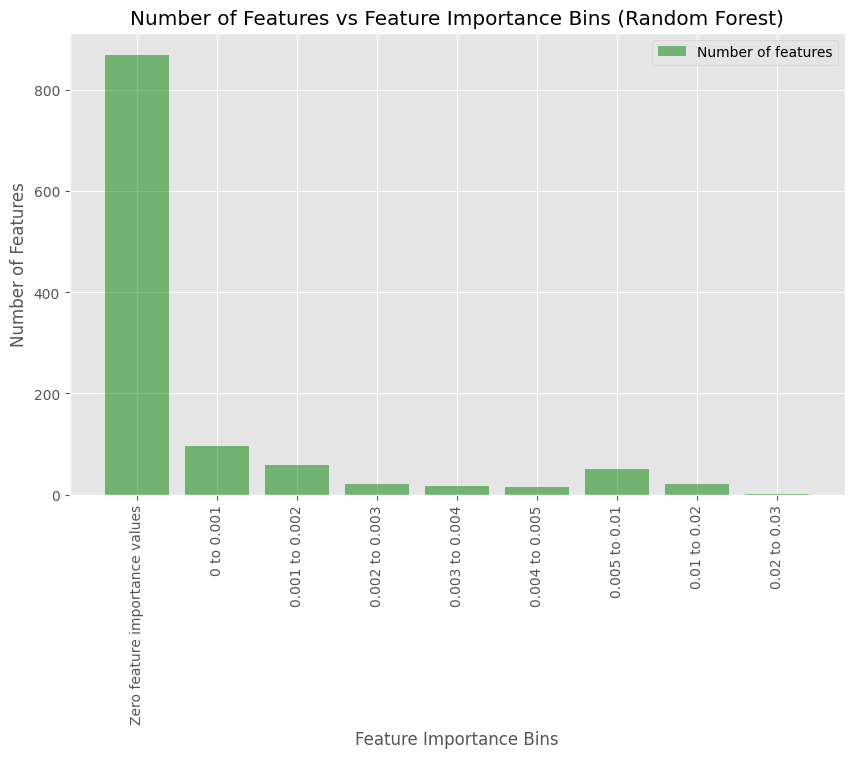

1152


In [480]:
importance_rf = rf_feature_importeaces
# importance_rf: Feature importance values from Random Forest
grouped_importance_rf_x = []
grouped_importance_rf = []

for i in range(0, len(bins) - 1):
    importance_in_bin = importance_rf[(importance_rf > bins[i]) & (importance_rf <= bins[i+1])]
    if len(importance_in_bin) > 0:
        grouped_importance_rf_x.append(len(importance_in_bin))
        grouped_importance_rf.append(importance_in_bin.mean())
    else:
        grouped_importance_rf_x.append(0)
        grouped_importance_rf.append(0)

grouped_importance_rf_x.insert(0, len(importance_rf[importance_rf == bins[0]]))
grouped_importance_rf.insert(0, importance_rf[importance_rf == bins[0]].mean())


fig, ax = plt.subplots(figsize=(10, 6))

# Plotting grouped Random Forest feature importance
ax.bar(range(len(grouped_importance_rf_x)), grouped_importance_rf_x, color='green', alpha=0.5, label='Number of features')
ax.set_xticks(range(len(grouped_importance_rf_x)))
ax.set_xticklabels(["Zero feature importance values"]+[f'{bins[i]} to {bins[i+1]}' for i in range(0,len(bins)-1)], rotation=90)
ax.set_xlabel('Feature Importance Bins')
ax.set_ylabel('Number of Features')
ax.set_title('Number of Features vs Feature Importance Bins (Random Forest)')
ax.legend()
plt.show()
print(sum(grouped_importance_rf_x))

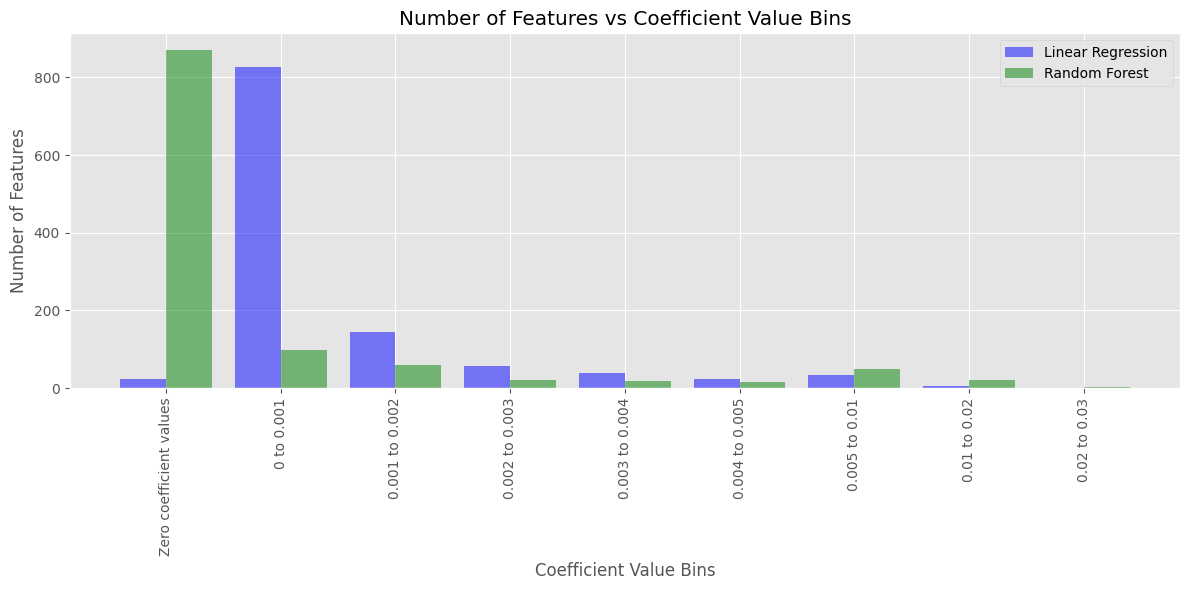

In [477]:
# Combine grouped_importance_rf_x and grouped_weights_lr_x using a DataFrame
df = pd.DataFrame({
    'Coefficient Value Bins': ['Zero coefficient values'] + [f'{bins[i]} to {bins[i+1]}' for i in range(len(bins)-1)],
    'Number of Features (LR)': grouped_weights_lr_x,
    'Number of Features (RF)': grouped_importance_rf_x
})

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting grouped Linear Regression weights
ax.bar(df.index - 0.2, df['Number of Features (LR)'], width=0.4, color='blue', alpha=0.5, label='Linear Regression')
# Plotting grouped Random Forest feature importance
ax.bar(df.index + 0.2, df['Number of Features (RF)'], width=0.4, color='green', alpha=0.5, label='Random Forest')

ax.set_xticks(df.index)
ax.set_xticklabels(df['Coefficient Value Bins'], rotation=90)
ax.set_xlabel('Coefficient Value Bins')
ax.set_ylabel('Number of Features')
ax.set_title('Number of Features vs Coefficient Value Bins')
ax.legend()
plt.tight_layout()
plt.show()


In [488]:
df_lr = pd.DataFrame({"Feature Names": X_test_extracted.columns,"LR Coefficients": weights_lr_normalized})
top_10_columns = df_lr.nlargest(10, 'LR Coefficients')
top_10_columns



,Feature Names,LR Coefficients
188,0_FFT mean coefficient_25,0.014293
1102,2_Spectral entropy,0.012870
845,2_FFT mean coefficient_15,0.011180
1105,2_Spectral roll-off,0.010843
1079,2_Maximum frequency,0.010843
856,2_FFT mean coefficient_16,0.010385
1028,2_FFT mean coefficient_9,0.009871
889,2_FFT mean coefficient_19,0.008775
472,1_FFT mean coefficient_16,0.008703
995,2_FFT mean coefficient_6,0.008164


In [491]:
importance_rf

array([0.01650779, 0.        , 0.0136402 , ..., 0.0004187 , 0.00102853,
       0.        ])

In [495]:
df_rf = pd.DataFrame({"Feature Names": X_test_extracted.columns,"RF Coefficients": importance_rf})
top_10_columns = df_rf.nlargest(10, 'RF Coefficients')
top_10_columns

,Feature Names,RF Coefficients
373,0_Wavelet standard deviation_8,0.023509
371,0_Wavelet standard deviation_6,0.023174
380,0_Wavelet variance_6,0.019629
382,0_Wavelet variance_8,0.019229
381,0_Wavelet variance_7,0.019099
333,0_Spectral distance,0.018780
372,0_Wavelet standard deviation_7,0.017086
0,0_Absolute energy,0.016508
356,0_Wavelet energy_1,0.014786
378,0_Wavelet variance_4,0.014695


In [448]:
from sklearn.linear_model import Lasso

# Create an instance of the Lasso model
lasso_model = Lasso(alpha=2.5, max_iter=5000)  # alpha = 2.5

# Fit the model to your training data
lasso_model.fit(X_train_extracted, Y_merged)

# Predict on the test set
y_pred = lasso_model.predict(X_test_extracted)

y_pred


array([1.9381981 , 3.20014894, 5.74954525, 2.31043104, 6.21468877,
       3.82288198, 5.87203832, 0.54962361, 1.38076731, 1.72346946,
       5.11931512, 5.67308019, 2.05949754, 4.54745486, 2.33978152,
       4.13275438, 5.18359321, 5.37411159, 0.71132259, 6.01434921,
       4.14532084, 0.67259375, 2.2603531 , 5.15575455, 1.69207672,
       1.94884701, 2.40303332, 5.75183942, 2.73380844, 4.08999138,
       4.35624635, 4.27640866, 4.09235323, 2.40485443, 2.00632168,
       2.26833131])

In [449]:
y_pred = np.floor(y_pred)
y_pred[y_pred == 0] = 1
y_pred

array([1., 3., 5., 2., 6., 3., 5., 1., 1., 1., 5., 5., 2., 4., 2., 4., 5.,
       5., 1., 6., 4., 1., 2., 5., 1., 1., 2., 5., 2., 4., 4., 4., 4., 2.,
       2., 2.])

In [450]:
acc = accuracy_score(y_test, y_pred)
acc

0.6388888888888888

In [451]:
learned_weights = lasso_model.coef_
learned_weights

array([-2.36475954e-03, -0.00000000e+00, -6.42070593e-18, ...,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00])

In [452]:
print(len(learned_weights[learned_weights != 0]))

31
